# Custom clustering
In this code we attempt to do custom clustering on the data. We will use the following steps:
- Preprocessing the data    
    - Get melspectogram of audio with 80 features per mel-frame. 



In [21]:
import librosa
import torch
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from utils_vad import (
    get_speech_timestamps,
)  # Assuming this file defines the get_speech_timestamps function
from preprocess import Wav2Mel
import torchaudio

import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mode



In [22]:
# Global variables used for preprocessing
SAMPLE_RATE = 16000
NORM_DB = -3
FFT_WINDOW_MS = 25
FFT_HOP_MS = 10
FRAME_SIZE = 40  # Adjust frame size if needed
BLOCK_SIZE = 50  # MFCC frames to stack together for embedding

# Path to audio file 
AUDIO_PATH = "../Dataset/Audio/Test/aepyx.wav"

In [23]:
# Load the models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pre-trained Dvector model --> Embedding model (modify paths as needed)
dvector_model = torch.jit.load("Pretrained Modules/dvector-step250000.pt")
dvector_model = dvector_model.to(device)

# V Pretrained VAD model --> VAD model (modify paths as needed)
vad_model = torch.jit.load("Pretrained Modules/silero_vad.jit")
vad_model = vad_model.to(device)


wave2mel = Wav2Mel(
    sample_rate=SAMPLE_RATE,
    norm_db=NORM_DB,
    fft_window_ms=FFT_WINDOW_MS,
    fft_hop_ms=FFT_HOP_MS,
    n_mels=40,
)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure the dvector_model is on the GPU
dvector_model.to(device)


# In the case that you wish to verify the model architecture
#!dvector_model.eval()
#!vad_model.eval()

RecursiveScriptModule(
  original_name=AttentivePooledLSTMDvector
  (lstm): RecursiveScriptModule(original_name=LSTM)
  (embedding): RecursiveScriptModule(original_name=Linear)
  (linear): RecursiveScriptModule(original_name=Linear)
)

In [24]:
wave_tensor_torch, wave_sampling_rate = torchaudio.load(AUDIO_PATH)
wave_tensor_torch = wave_tensor_torch.to(device)


speech_segments = get_speech_timestamps(wave_tensor_torch, model=vad_model)
print(speech_segments)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1527: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  return forward_call(*args, **kwargs)


[{'start': 39456, 'end': 96224}, {'start': 98336, 'end': 133088}, {'start': 138272, 'end': 184288}, {'start': 187424, 'end': 236512}, {'start': 239648, 'end': 280032}, {'start': 283680, 'end': 294880}, {'start': 304160, 'end': 335328}, {'start': 337440, 'end': 380896}, {'start': 385056, 'end': 410080}, {'start': 418336, 'end': 432608}, {'start': 452128, 'end': 521184}, {'start': 525344, 'end': 532448}, {'start': 550432, 'end': 605152}, {'start': 607264, 'end': 633824}, {'start': 643616, 'end': 1035232}, {'start': 1072160, 'end': 1409504}, {'start': 1421344, 'end': 1440224}, {'start': 1454624, 'end': 1486816}, {'start': 1492000, 'end': 1511392}, {'start': 1517088, 'end': 1553376}, {'start': 1559584, 'end': 1572825}]


In [25]:
def get_frames(mel_tensor, block_size):
    return mel_tensor.unfold(0, block_size, block_size).mT

def get_frame_embeddings(mel_frames):
    embeddings = torch.empty(mel_frames.shape[0], 256, device=device)
    for frame_idx in range(mel_frames.shape[0]):
        frame = mel_frames[frame_idx].to(device)  # Move the frame to the GPU
        embeddings[frame_idx, :] = dvector_model.embed_utterance(frame)
    return embeddings.detach().cpu().numpy()

wave_tensor_torch, wave_sampling_rate = torchaudio.load(AUDIO_PATH)
print("Shape of torch: ",wave_tensor_torch.shape)
wave_tensor, mel_tensor = wave2mel(wave_tensor_torch, wave_sampling_rate)

# Get the mel_framse and embeddings
mel_frames = get_frames(mel_tensor, BLOCK_SIZE)
embeddings = get_frame_embeddings(mel_frames)


print(mel_frames.shape)
print(embeddings.shape)


Shape of torch:  torch.Size([1, 1572825])


/tmp/ipykernel_52310/3722215312.py:8: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  embeddings[frame_idx, :] = dvector_model.embed_utterance(frame)


torch.Size([166, 50, 40])
(166, 256)


### Predictions 
In this part we do the Clustering

Distance:  [0.73935161 0.92978232 0.70140643 ... 1.20170895 1.14308518 1.21044839]
A (166, 166)
Distance (13695,)


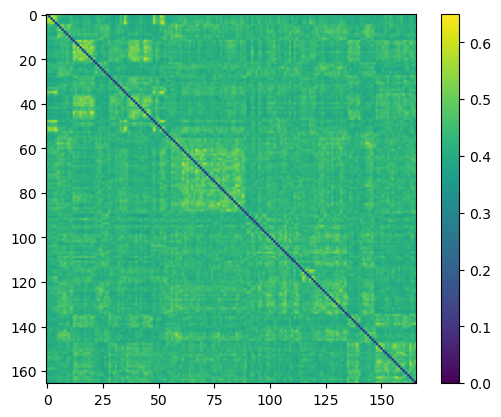

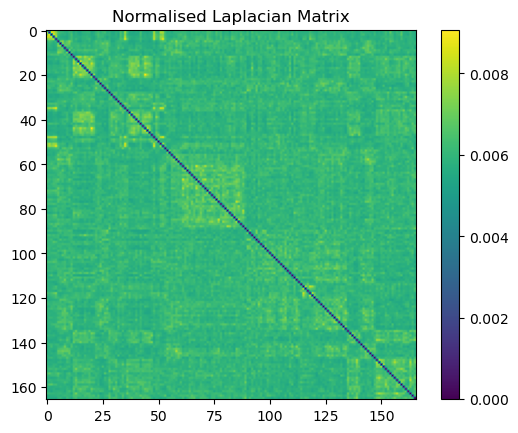

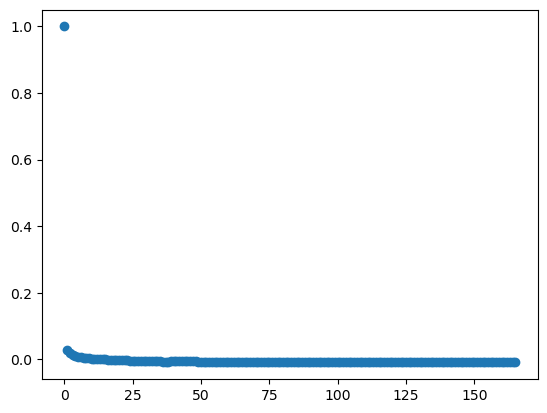

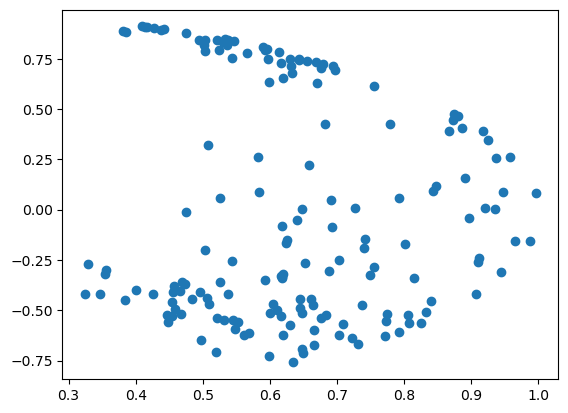

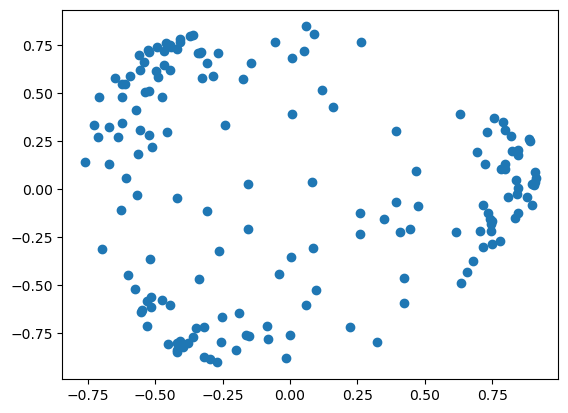

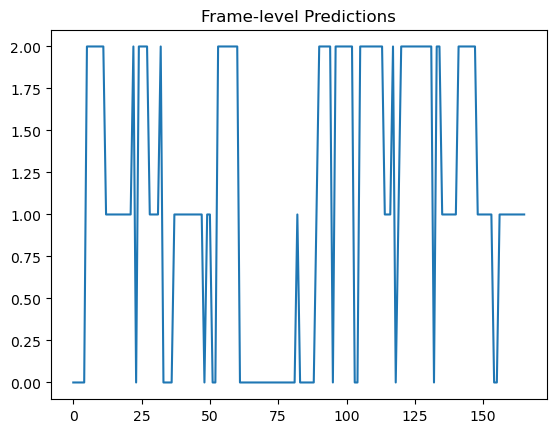

[0 0 0 0 0 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 2 0 2 2 2 2 1 1 1 1 2 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 2 2 2 2 2 0 2 2 2 2 2 2 2 0 0 2 2 2 2 2 2
 2 2 2 1 1 1 2 0 1 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 1 1 1 1 1 1 2 2 2 2 2 2 2
 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1]


In [36]:
distance = pdist(embeddings, metric="euclidean")
print("Distance: ", distance)

A = 1 / (1 + distance)
A = squareform(A)
print("A", A.shape)
print("Distance", distance.shape)
A = A - np.diag(np.diag(A))  # set diagonal to zero
plt.imshow(A)
plt.colorbar()
plt.show()

def normalized_laplacian_matrix(A):
    # A is an adjacency matrix
    D = np.sum(A, axis=1)
    inv_sqrt_D = np.power(D, -0.5)
    L = inv_sqrt_D.reshape(-1, 1) * A * inv_sqrt_D.reshape(1, -1)
    return L

L = normalized_laplacian_matrix(A)
# Add colorbar
# Title it normalised laplacian matrix
plt.title("Normalised Laplacian Matrix")
plt.imshow(L)
plt.colorbar()
plt.show()

w, v = np.linalg.eig(L)
eigenvalues = np.real(w)
#eigenvalues = eigenvalues[eigenvalues>0.05]
#eigenvectors = np.real(v[:, 0:len(eigenvalues)])
#print(np.diff(eigenvalues))
num_vectors = np.argmin(np.diff(eigenvalues)) + 1
num_vectors = 3
eigenvectors = np.real(v[:, 0:num_vectors])
plt.scatter(range(len(eigenvalues)), eigenvalues)
plt.show()

norm_eigenvectors = eigenvectors / np.linalg.norm(eigenvectors, axis=1, keepdims=True)

plt.scatter(norm_eigenvectors[:, 0], norm_eigenvectors[:, 1])
plt.show()
plt.scatter(norm_eigenvectors[:, 1], norm_eigenvectors[:, 2])
plt.show()

frame_predictions = KMeans(n_clusters=norm_eigenvectors.shape[1], n_init=5).fit_predict(norm_eigenvectors)
plt.plot(frame_predictions)
plt.title("Frame-level Predictions")
plt.show()
print(frame_predictions)




In [35]:
# RTTM file generation
def write_rttm(predictions, speech_segments, output_path, file_id, sample_rate):
    with open(output_path, 'w') as f:
        for i, segment in enumerate(speech_segments):
            start_time = segment['start'] / sample_rate
            duration = (segment['end'] - segment['start']) / sample_rate
            speaker_id = predictions[i]
            f.write(f"SPEAKER {file_id} 1 {start_time:.2f} {duration:.2f} <NA> <NA> {speaker_id} <NA>\n")


print("Size of predictions: ", len(predictions))
print("Size of speech_segments: ", len(speech_segments))


# Example usage:
output_path = "output.rttm"
write_rttm(predictions, speech_segments, output_path, AUDIO_PATH, SAMPLE_RATE)

Size of predictions:  2
Size of speech_segments:  21


IndexError: list index out of range

In [32]:
import torchaudio

def write_rttm_file(predictions, speech_segments, filename, sampling_rate):
    frame_rate = sampling_rate / (FFT_HOP_MS / 1000)

    with open(filename, "w") as file:
        for segment in speech_segments:
            segment_start = segment['start'] / sampling_rate
            segment_end = segment['end'] / sampling_rate
            
            start_frame = int(segment_start * frame_rate)
            end_frame = int(segment_end * frame_rate) - 1

            # Ensure frame indices are within bounds
            if start_frame < 0: start_frame = 0
            if end_frame >= len(predictions): end_frame = len(predictions) - 1
            
            segment_predictions = predictions[start_frame:end_frame + 1]
            print(f"Segment start: {segment_start}, end: {segment_end}")
            print(f"Frame range: start={start_frame}, end={end_frame}")
            print(f"Segment predictions: {segment_predictions}")

            if len(segment_predictions) > 0:
                speaker_label = max(set(segment_predictions), key=list(segment_predictions).count)
            else:
                speaker_label = 'Unknown'
            
            file.write(f"SPEAKER somefile 1 {segment_start:.2f} {segment_end - segment_start:.2f} <NA> <NA> {speaker_label} <NA>\n")

# Example usage (assuming `predictions` and `speech_segments` are defined)
wave_tensor_torch, wave_sampling_rate = torchaudio.load(AUDIO_PATH)

# Dummy variables for example (replace with actual data)
predictions = [1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 2, 1, 0, 1, 1, 0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 0, 2,
               2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
               1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
               2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0,
               2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
               2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
               1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
speech_segments = [
    {'start': 0, 'end': 320},  # dummy segment (replace with actual data)
    {'start': 320, 'end': 640}
]

write_rttm_file(predictions, speech_segments, "output.rttm", sampling_rate=wave_sampling_rate)

print("RTTM file generated: output.rttm")


Segment start: 0.0, end: 0.02
Frame range: start=0, end=255
Segment predictions: [1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 2, 1, 0, 1, 1, 0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 0, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Segment start: 0.02, end: 0.04
Frame range: start=32000, end=255
Segment predictions: []
RTTM file generated: output.rttm
